In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil

import wfdb
from wfdb import processing

%matplotlib inline

/home/singuyen/anaconda3/envs/biosignal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Reading records and annotations

In [73]:
record_id = 'I09'
segment_len = 2000
start=3500
end=start+segment_len
record_path = '../incartDb/'+record_id

In [74]:
# Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
#record = wfdb.rdrecord(record_path, sampfrom=start, sampto=end) 
#wfdb.plot_wfdb(record=record, annotation=annotation,
#               title='Record I01',
#               time_units='seconds', figsize=(10,20))
#print(record.__dict__)

signal, fields = wfdb.rdsamp(record_path, sampfrom=start, sampto=end, channels=[0,9]) 
data = np.mean(signal, axis=1)
fs = fields['fs']

## Write record into .csv file

In [75]:
time = np.linspace(0, segment_len/fs, segment_len)
print(len(time))
time

2000


array([0.00000000e+00, 3.89299708e-03, 7.78599416e-03, ...,
       7.77431517e+00, 7.77820817e+00, 7.78210117e+00])

In [76]:
file = pd.DataFrame()
file['timestamp'] = time
file['ecg_measurement'] = data
file

,timestamp,ecg_measurement
0,0.000000,2.767717
1,0.003893,2.805118
2,0.007786,2.818898
3,0.011679,2.791339
4,0.015572,2.787402
5,0.019465,2.771654
6,0.023358,2.765748
7,0.027251,2.785433
8,0.031144,2.779528
9,0.035037,2.777559


In [77]:
file_name = '/tmp/incartDb_' + record_id + '_' + str(start) + '.csv'
file.to_csv(file_name, index=False)

## Peak detection with `qrs_detector` from c-labpl

In [78]:
import sys
sys.path.insert(0, '/home/singuyen/project_biosignal/c-labpl.qrs_detector.master')

from QRSDetectorOffline import QRSDetectorOffline

qrs peaks indices
[  19  313  502  688  875 1061 1244 1414 1581 1747 1984]
noise peaks indices
[]


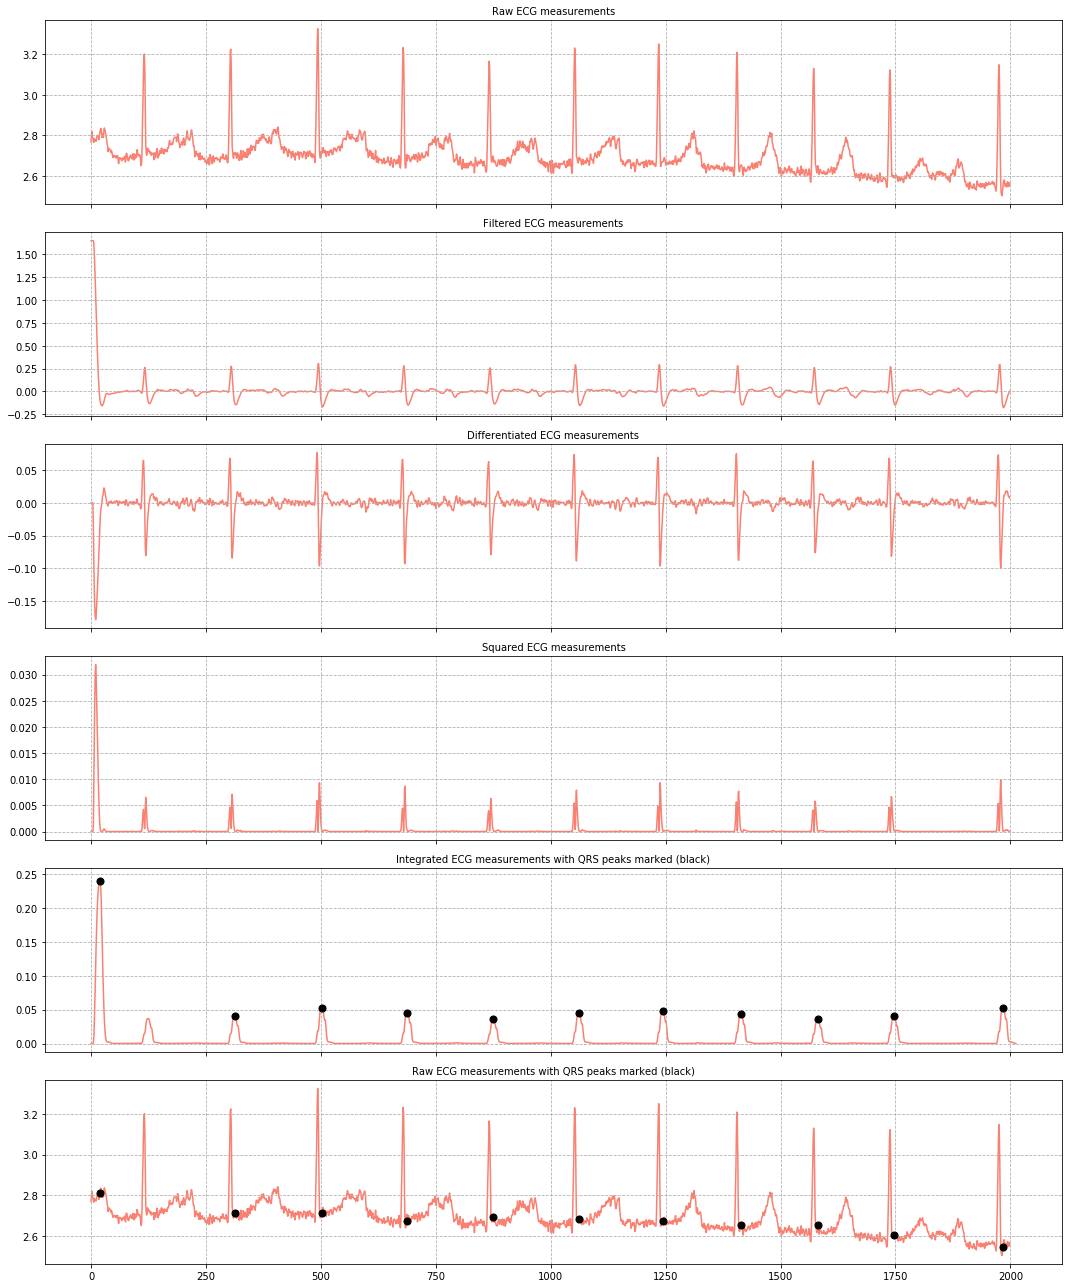

In [79]:
qrs_detector = QRSDetectorOffline(ecg_data_path=file_name, fs=fs, 
                                  findpeaks_limit=0.02, findpeaks_spacing_factor=0.2,
                                  verbose=True,
                                  log_data=False, plot_data=True, show_plot=True)

In [80]:
qrs_detector.detected_peaks_indices

array([  19,  125,  313,  502,  688,  875, 1061, 1244, 1414, 1581, 1747,
       1984])

## Validation

In [81]:
detected_inds = qrs_detector.qrs_peaks_indices
detected_inds

array([  19,  313,  502,  688,  875, 1061, 1244, 1414, 1581, 1747, 1984])

In [82]:
detected_inds + start

array([3519, 3813, 4002, 4188, 4375, 4561, 4744, 4914, 5081, 5247, 5484])

In [83]:
annotation = wfdb.rdann(record_path, 'atr', sampfrom=start, sampto=end)
annotation.sample

array([3615, 3804, 3993, 4179, 4366, 4552, 4734, 4905, 5072, 5238, 5475])

In [84]:
# Compare detected qrs complexes to reference annotation.
comparitor = processing.compare_annotations(ref_sample = annotation.sample,
                                            test_sample = detected_inds+start,
                                            window_width = int(0.1 * fs),
                                            signal = signal)

# Print the results
comparitor.print_summary()

11 reference annotations, 11 test annotations

True Positives (matched samples): 10
False Positives (unmatched test samples: 1
False Negatives (unmatched reference samples): 1

Specificity: 0.9091 (10/11)
Positive Predictivity: 0.9091 (10/11)
False Positive Rate: 0.0909 (1/11)
